In [1]:
import datetime, json, re, math, sys
import numpy as np
import numpy #lol
import matplotlib.pyplot as plt
from scipy.stats import linregress as lm
import random as ra
from collections import Counter, defaultdict
from __future__ import division
% matplotlib inline
#import the files
sys.path.append('../API')
import main

# Functions
## Mu analysis

In [29]:
def preprocess(text):
    counts = Counter()
    text = text.encode("utf8")
    words = []
    for word in re.split(" ", text):
        if word not in counts:
            words.append(word)
        counts[word] += 1
        
    return counts

def order(counts):
    words = counts.keys()
    ps = np.array(counts.values())
    ps = ps/float(sum(ps))
    N = len(words)
    return np.random.choice(words, size=N, replace=False, p=ps)

def innovationrate(counts, reps = 2, termmax = 100):
    
    N = len(counts)    
    FN = sum(counts.values())

    ns = range(1,N+1)
    Mn = [0 for n in ns]
    
    for rep in range(reps):
        n = 0
        Fn = 0
        Msum = 0
        for n, word in zip(ns, order(counts)):

            f = counts[word]
            Fn += f

            if n == N:
                break 

            ## compute In and Jn
            In = Fn - (n - 1 + int(Msum))
            Jn = FN - (n - 1 + int(Msum))

            ## compute the average
            ms = np.array(range(1, min([In,termmax])+1))

            logfacts = np.log10(In - ms) - np.log10(Jn - ms)
            prods = 10**np.cumsum(logfacts)
            terms = ms*prods*(Jn - In)/(Jn - ms)
            termsum = sum(terms)
            Mn[n] += termsum/reps

            Msum += termsum

    return 1/(1 + np.array(Mn)), np.array(ns)

def decayExponent(text):
    counts = preprocess(text)
    reps = int(round(0.5 + (5000. / len(counts))))
    termmax = 1000
    alphas, ns = innovationrate(counts, reps, termmax)
    
    ix = range(int(len(ns)*1/3.),len(ns))

    x = np.log10(ns)[ix]
    y = np.log10(alphas)[ix]

    mu, b, r, p, err = lm(x,y)

    return -mu, sum(counts.values())

### The actual function

In [30]:
def getMu(text):
    if text.strip(): #in case there's no text
        mu, numwords = decayExponent(text)
        return mu, numwords
    else:
        return 0.0, 0

## Number of links

In [31]:
def getNumLinks(text):
    links = re.findall(r'(https?://[^\s]+)', text)
    return len(links)

## Deviation from thread mean

In [32]:
def thread_deviation(comment_dict):
    """get the deviation from the thread's mean response time for
    the comment"""
    try:
        thread_id = comment_dict['id'].split('_')[0]
        thread_times = main.threadResponse(thread_id)
        thread_mean = np.mean(thread_times)
        thread_deviation = comment_dict['response'] - thread_mean
        return thread_deviation
    except:
        return None

# Computation
First we need to get the comments data

In [33]:
all_comms = defaultdict(list)
humans = defaultdict(list)
bots = defaultdict(list)

with open('../../data/TRAIN.json', 'r') as f:
    TRAIN = json.load(f)
    
for comment in TRAIN:
    comment_id = comment['id']
    all_comms[comment_id] = [None] * 6
    if comment['bot']:
        bots[comment_id] = [None] * 6
    else:
        humans[comment_id] = [None] * 6

## Run the calculation for all comments

In [34]:
i = 0
for comm in TRAIN:
    comm_id = comm['id']
    text = comm['message']
    if i % 1000 == 0:
        print comm_id
    i += 1
    
    mu1, mu2 = getMu(text)
    num_links = getNumLinks(text)
    response = comm['response']
    deviation = thread_deviation(comm)
    length = len(text)
    
    all_comms[comm_id][0], all_comms[comm_id][1] = mu1, mu2   #both mu values
    all_comms[comm_id][2] = num_links  #number of links
    all_comms[comm_id][3] = response  #response time
    all_comms[comm_id][4] = deviation  #mean thread deviation time
    all_comms[comm_id][5] = length  #comment length
    
    if comm['bot']:
        bots[comm_id][0], bots[comm_id][1] = mu1, mu2
        bots[comm_id][2] = num_links
        bots[comm_id][3] = response
        bots[comm_id][4] = deviation
        bots[comm_id][5] = length
    
    else:
        humans[comm_id][0], humans[comm_id][1] = mu1, mu2
        humans[comm_id][2] = num_links
        humans[comm_id][3] = response
        humans[comm_id][4] = deviation
        humans[comm_id][5] = length
    
# Dump the data
with open('TRAIN_STATS.json', 'w') as f2:
    json.dump(all_comms, f2, indent = 4, sort_keys = True)
    
with open('HUMAN_STATS.json', 'w') as f3:
    json.dump(humans, f3, indent = 4, sort_keys = True)
    
with open('BOT_STATS.json', 'w') as f4:
    json.dump(bots, f4, indent = 4, sort_keys = True)
    

1252678871491831_1252713878154997


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/scipy/stats/_stats_mstats_common.py:106: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python2.7/site-packages/scipy/stats/_stats_mstats_common.py:116: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python2.7/site-packages/scipy/stats/_stats_mstats_common.py:118: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


10153844429351680_10153844658751680
1285887041453126_1285916618116835
1290121891029641_1810465029197886
1038834739548085_1040062552758637
1286584094716754_1286587904716373
10153860289606680_10153860448211680
1464677133543260_1464876773523296
1250043525088699_1027187967393997
10153850782621680_10153850955311680
1282229875152176_1282243208484176
1290530250988805_1290649274310236
1291465524228611_1291471324228031
1248672898559095_1789126087978830
1282551825119981_1282657765109387
1290571237651373_1290589834316180
1291673040874526_1291676560874174
1291208607587636_1291230947585402
1290509944324169_1290632867645210
10153849865081680_10153852545926680
1247104542049264_1247156718710713
10153859749961680_10153859758791680
1291455630896267_1291488454226318
10153844396341680_10153844431701680
1284230444952119_604077339764287
1285188088189688_1285237221518108
1281555051886325_1281633851878445
1253137848112600_1253691548057230
1284280401613790_1284432578265239
10153848618131680_10153848690941680
1

In [13]:
all_comms['1253259148100470_1253304858095899']

# Dump the data
with open('TRAIN_STATS.json', 'w') as f2:
    json.dump(all_comms, f2, indent = 4, sort_keys = True)

In [2]:
with open('TRAIN_STATS.json', 'r') as f:
    TRAIN_STATS = json.load(f)

# EDA

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
column = ['mu_1', 'mu_2', 'links', 'response', 'thread deviation', 'length']
data = pd.DataFrame.from_dict(TRAIN_STATS,
                              orient = 'index')

In [6]:
data.head()

,0,1,2,3,4,5
1253259148100470_1253304858095899,0.233297,39,0,159,-225.733734,197
1283143941727436_1283412085033955,0.246400,517,0,109,-554.262376,3511
1252944911465227_1253019028124482,0.000000,0,0,24,-1350.667996,0
1462846610392979_1462869327057374,0.110497,13,0,690,-2094.500000,84
1285756448132852_1285932008115296,0.019181,28,0,4255,1932.101266,157


## Mu_1 Analysis
### All users

0.082346869445028087

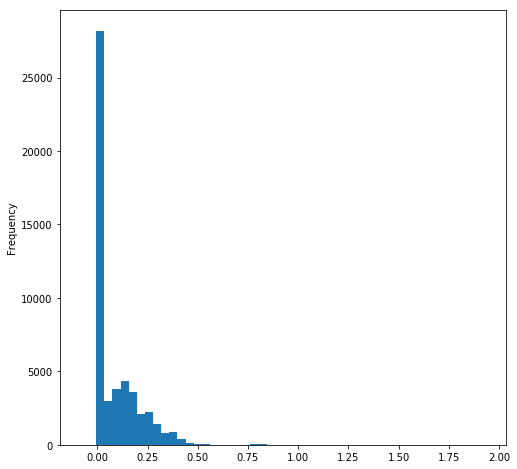

In [76]:
data[0].plot.hist(figsize=(8,8), bins = 50)
np.mean(data[0])

In [25]:
with open('HUMAN_STATS.json', 'r') as f:
    HUMAN = json.load(f)
    
with open('BOT_STATS.json', 'r') as f2:
    BOT = json.load(f2)
    
human_df = pd.DataFrame.from_dict(HUMAN, orient = 'index')
bot_df = pd.DataFrame.from_dict(BOT, orient = 'index')

### Humans

0.051623663539319756

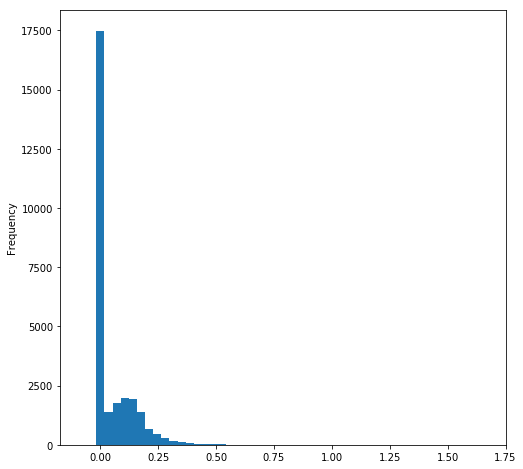

In [75]:
human_df[0].plot.hist(figsize = (8,8), bins = 50)
np.mean(human_df[0])

### Bots

0.11922106867644852

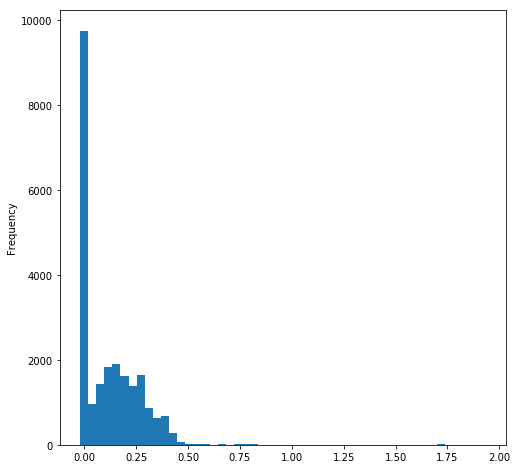

In [73]:
bot_df[0].plot.hist(figsize = (8,8), bins = 50)
np.mean(bot_df[0])

## Mu_2 Analysis

### Humans

18.938127259824959

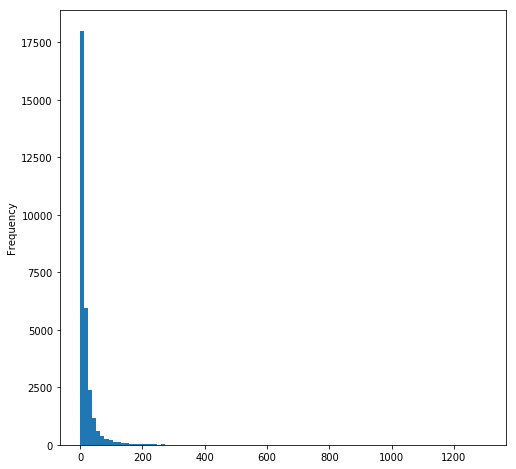

In [72]:
human_df[1].plot.hist(figsize = (8,8), bins = 100)
np.mean(human_df[1])

### Bots

151.50387225548903

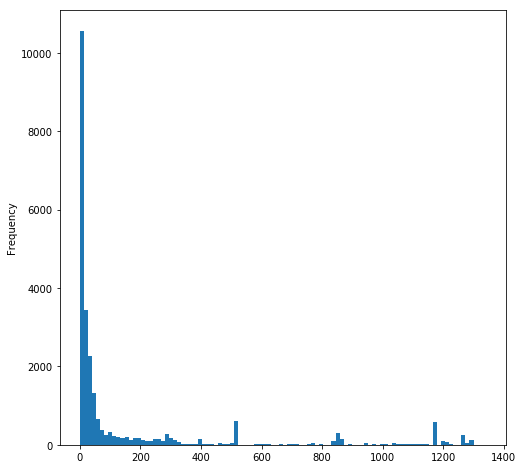

In [71]:
bot_df[1].plot.hist(figsize = (8,8), bins = 100)
np.mean(bot_df[1])

## Num links analysis
### Humans

0.038590207143581252

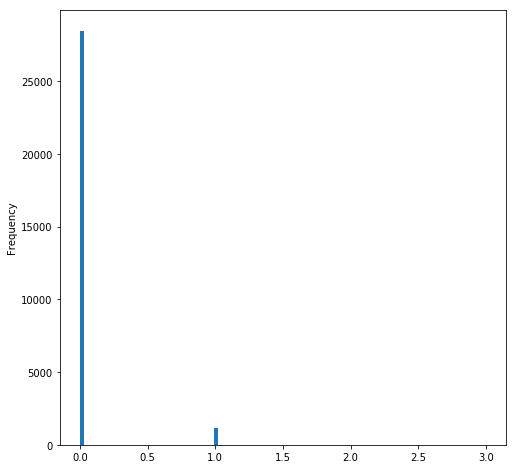

In [70]:
human_df[2].plot.hist(figsize = (8,8), bins = 100)
np.mean(human_df[2])

### Bots

0.21137724550898204

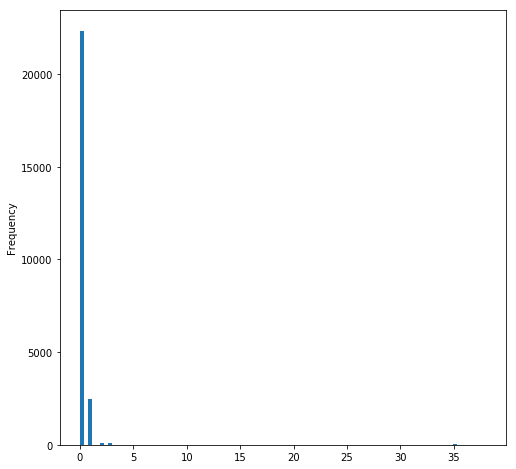

In [69]:
bot_df[2].plot.hist(figsize = (8,8), bins = 100)
np.mean(bot_df[2])

## Response time analysis
### Humans

1568.6984421991688

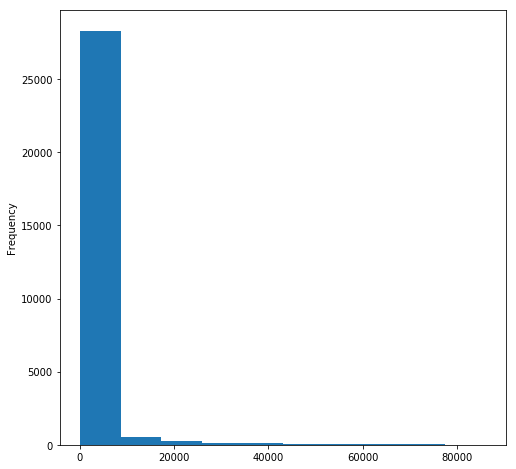

In [68]:
human_df[3].plot.hist(figsize = (8,8), bins = 10)
np.mean(human_df[3])

### Bots

1086.5003193612774

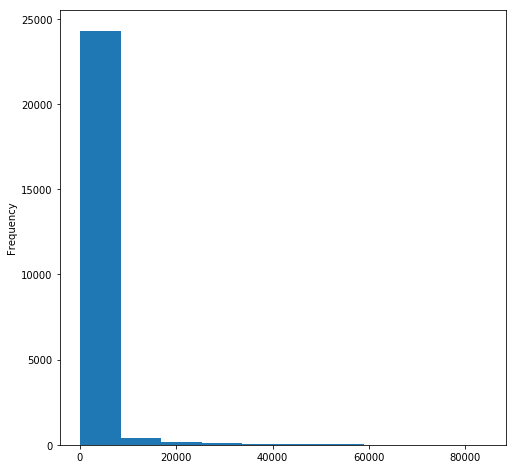

In [67]:
bot_df[3].plot.hist(figsize = (8,8), bins = 10)
np.mean(bot_df[3])

## Thread deviation analysis
### Human

722.4971369790394

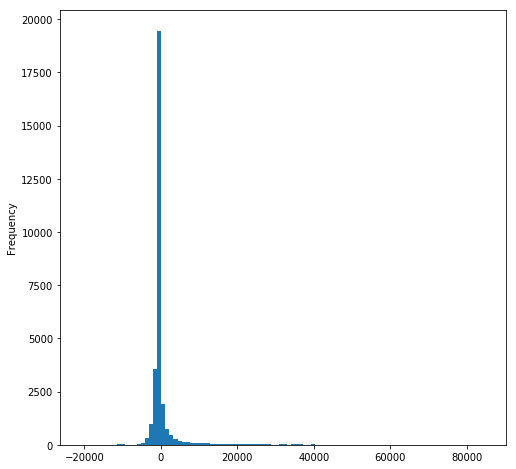

In [65]:
human_df[4].plot.hist(figsize = (8,8), bins = 100)
np.mean(human_df[4])

### Bot

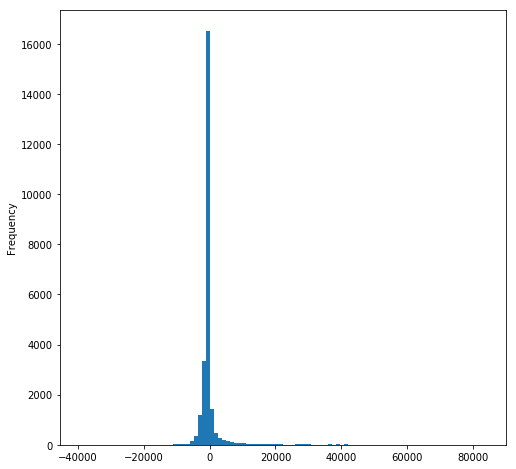

In [63]:
bot_df[4].plot.hist(figsize = (8,8), bins = 100)

In [64]:
np.mean(bot_df[4])

-28.042478383429561

## Comment length analysis
### Human

107.23143986753624

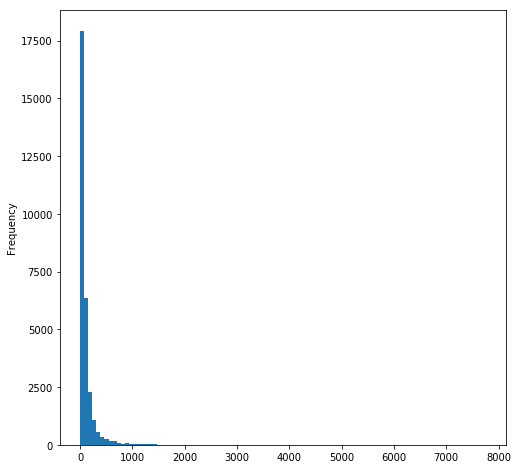

In [77]:
human_df[5].plot.hist(figsize = (8,8), bins = 100)
np.mean(human_df[5])

### Bot

969.32966067864277

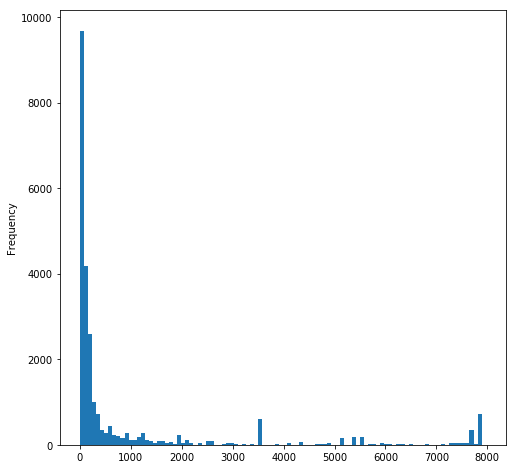

In [78]:
bot_df[5].plot.hist(figsize = (8,8), bins = 100)
np.mean(bot_df[5])